### 1. Load the dataset

**[1.1] Automatic reload modules**

In [148]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump

**[1.3] Load the datasets**

In [150]:
X_train = pd.read_csv('../data/processed/X_train.csv')
X_val   = pd.read_csv('../data/processed/X_val.csv')
X_test  = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_val   = pd.read_csv('../data/processed/y_val.csv')
y_test = pd.read_csv('../data/interim/y_test.csv')

In [151]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()

In [152]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(33001, 58)
(8251, 58)
(4970, 58)


### 3. Train XGBoost Default Model - Hyperparameter Tuning with RandomSearchCV

**[3.1] Instantiate and fit the model**

In [153]:
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=8)

**[3.2] Parameters dictionary**

In [154]:
from scipy.stats import randint

param_ran = {
    'gamma': randint(0, 10),
    'max_depth': randint(1, 10),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': randint(1, 99)
}

**[3.3] Instantiate and fit the hyperparameters wit Stratified KFold**

In [155]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
ransearch = RandomizedSearchCV(xg, param_ran, cv=skf, random_state=8)

In [156]:
ransearch.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importanc...
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028C3F5F6CD0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028C3AD4C090>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028C3F5F7950>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028C3F5F6C50>},
                   random_state=8)

**[3.4] Display the best set of parameters**

In [157]:
ransearch.best_params_

{'gamma': 0, 'max_depth': 8, 'min_child_weight': 3, 'scale_pos_weight': 39}

**[3.5] Evaluation metrics for hyperparameters**

In [158]:
ransearch.best_score_

np.float64(0.9953334618721682)

In [159]:
print("RanCV_Train:", f'{ransearch.score(X_train, y_train):.4f}')
print("RanCV_val:", f'{ransearch.score(X_val, y_val):.4f}')

RanCV_Train: 1.0000
RanCV_val: 0.9959


**[3.6] Make prediction on training data**

In [160]:
y_train_pred = ransearch.best_estimator_.predict_proba(X_train)[:, 1]
y_val_pred = ransearch.best_estimator_.predict_proba(X_val)[:, 1]

**[3.7] Performance metric - AUROC**

In [161]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [162]:
print("Train - AUROC:\n", f'{roc_auc_score(y_train, y_train_pred):.4f}')
print("Val - AUROC:\n", f'{roc_auc_score(y_val, y_val_pred):.4f}')

Train - AUROC:
 1.0000
Val - AUROC:
 0.9980


**Plot the AUROC curve**

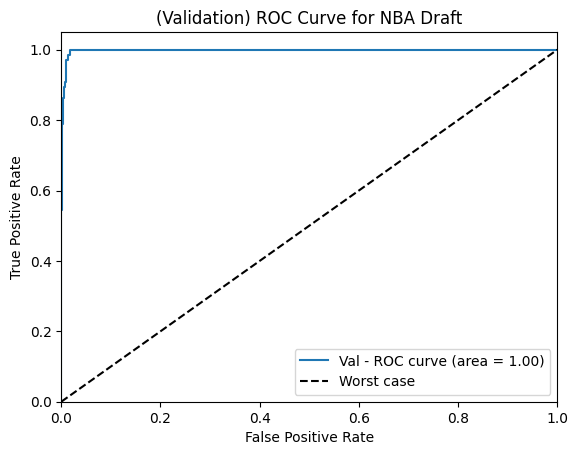

In [163]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred) 
roc_auc = auc(fpr, tpr)
plt.figure()  
plt.plot(fpr, tpr, label='Val - ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Worst case')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(Validation) ROC Curve for NBA Draft')
plt.legend()
plt.show()

**[3.8] Predict on test data**

In [164]:
y_test_pred = ransearch.best_estimator_.predict_proba(X_test)[:, 1]

#Dataframe for pred result
y_pred = y_test
y_pred.loc[:, 'drafted'] = y_test_pred

print(y_pred.describe().round(5))

y_pred = pd.DataFrame(y_pred)

#Save the result to CSV file
y_pred.to_csv('../data/external/at1_pred_week3.5.csv', index=False)

          drafted
count  4970.00000
mean      0.00575
std       0.07090
min       0.00000
25%       0.00000
50%       0.00000
75%       0.00001
max       0.99997


### 4. Feature Importance

In [165]:
feature = ransearch.best_estimator_.feature_importances_

In [166]:
#Dataframe of feature importance
feat_imp_rf_df = pd.DataFrame(
    {'feature': X_train.columns,
     'feature_importance': feature})

In [167]:
#Sort the dataframe
feat_imp_rf_df = feat_imp_rf_df.sort_values('feature_importance', ascending=False).reset_index(drop=True)
feat_imp_rf_df

,feature,feature_importance
0,pick,0.835848
1,porpag,0.017010
2,DRB_per,0.007903
3,pts,0.007595
4,yr_Jr,0.007171
5,GP,0.006774
6,dreb,0.005705
7,midmade,0.005447
8,rimmade,0.004903
9,mp,0.004886


In [168]:
#Visualize the feature importance
import altair as alt

alt.Chart(feat_imp_rf_df).mark_bar().encode(
    x='feature_importance',
    y=alt.Y("feature", sort='-x'),
    tooltip=['feature','feature_importance']
)

alt.Chart(...)